In [2]:
import sys
import baysian_neural_decoding as mb
import MI_beh_plots as mbp
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
# For 13" macbook air 2012 DPI = 128
# For 21" iMac 2012 DPI = 102 
plt.rcParams.update({'xtick.labelsize': 9, 
                     'ytick.labelsize': 9, 
                     'font.size': 9, 
                     'font.family': 'Arial',
                     'savefig.dpi': 72.0,
                     'figure.dpi': 128})

%run animal_info # Dictionary containing file information

/Users/badr/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/badr/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
ANIMAL = 'PFC_12032013'
NEURON = [5]
TRIAL_DURATION = ANIMALS[ANIMAL]['trial_duration']
RESOLUTION = .1
BEGINNING_TIME = -.3
ENDING_TIME = 2.5
PRE_POKE_TIME = -2.5
CUTOFF = TRIAL_DURATION

event_set, spike_set = mb.load_events_spikes_script(neuron_num = NEURON, **ANIMALS[ANIMAL])
st0, s0, a0, np0, r0 = mb.create_complete_table(event_set, spike_set, ANIMALS[ANIMAL]['variables'], 
                                                 trial_duration = TRIAL_DURATION, 
                                                 pre_trial_duration = TRIAL_DURATION)

# Creating a nosepoke list that repalces the nans from withhold with the average nosepoke
avg_np = np0[np.invert(np.isnan(np0))].mean()
np1 = np0.copy()
np1[np.isnan(np1)] = avg_np
r0_plot = [np.array([ np.array(resp[(resp > BEGINNING_TIME)*(resp < ENDING_TIME)]) for resp in response ]) for response in r0]

# Generating responses and stimulus times for nosepoke locked rasters
r_np = [np.array([np.array(resp[(resp > (PRE_POKE_TIME + nosepoke))*(resp < nosepoke)]) - nosepoke for nosepoke, resp in zip(np1, response)]) for response in r0]             
np2 = []
for nosepoke in np0:
    if np.isnan(nosepoke):
        np2.append(np.nan)
    else:
        np2.append(0)        
np2 = np.array(np2)

# Creating a data sets for statistical comparison
r1 = [np.array([ np.array(resp[(resp > 0)*(resp < nosepoke)]) for resp, nosepoke in zip(response, np1) ]) for response in r0]
r1_T = [np.array([ np.array(resp[(resp > 0)*(resp < nosepoke)]) for resp, nosepoke, stimulus in zip(response, np1, s0) if stimulus == 'T' ]) for response in r0]
r1_F = [np.array([ np.array(resp[(resp > 0)*(resp < nosepoke)]) for resp, nosepoke, stimulus in zip(response, np1, s0) if stimulus == 'F' ]) for response in r0]
pre_r1 = [np.array([ np.array(resp[(resp > -nosepoke)*(resp < 0)]) + nosepoke for resp, nosepoke in zip(response, np1) ]) for response in r0]

r2 = [np.array([ np.array(resp[(resp > -.1)*(resp < .1)]) for resp, nosepoke in zip(response, np1) ]) for response in r0]
r2_T = [np.array([ np.array(resp[(resp > -.1)*(resp < .1)]) for resp, nosepoke, stimulus in zip(response, np1, s0) if stimulus == 'T' ]) for response in r0]
r2_F = [np.array([ np.array(resp[(resp > -.1)*(resp < .1)]) for resp, nosepoke, stimulus in zip(response, np1, s0) if stimulus == 'F' ]) for response in r0]

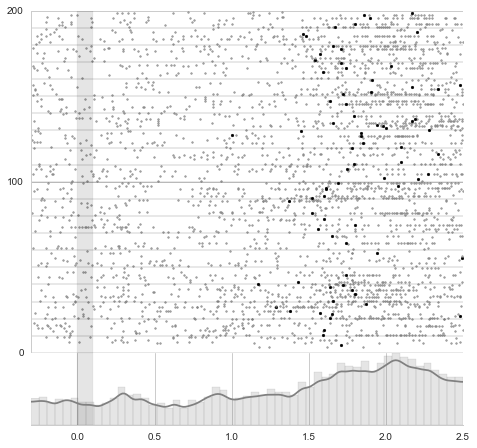

In [9]:
# Trial number
NUM = 0
mbp.plot_raster(r0_plot[NUM], np0, color = 'grey', beginning_time = BEGINNING_TIME)

In [2]:
BIN_SIZE = .050

def flatten(list_of_lists):
    flat_list = np.array([item for items in list_of_lists for item in items])
    return(flat_list)

def spike_counts(spike_times, time, bin_size=.050):
    time_counts = np.array([sum((spike_times >= start)*(spike_times < (start + bin_size))) 
                   for start in np.arange(0, time, bin_size)])
    return(Counter(time_counts))

def paired_counts(response, time_intervals=[(-BIN_SIZE, 0), (0, BIN_SIZE)]):
    spike_counts = []
    for time_interval in time_intervals:
        spike_counts.append(sum((response>=time_interval[0])*(response<time_interval[1])))
    return(tuple(spike_counts))

def counters_to_contingency(list_of_counters):
    max_spikes = max([max(counter.keys()) for counter in list_of_counters])
    num_groups = len(list_of_counters)
    contingency = np.zeros((max_spikes + 1, num_groups))
    for i in range(max_spikes + 1):
        for j in range(num_groups):
            contingency[i, j] = list_of_counters[j][i]
    return(contingency)

def counter_to_list(counter):
    counter_list = []
    for value, count in counter.iteritems():
        counter_list.extend(count*[value])
    return(counter_list)

def my_shuffle(an_array):
    np.random.shuffle(an_array)
    return(an_array)

In [3]:
from scipy.stats import chi2_contingency, wilcoxon, mannwhitneyu, shapiro, linregress

def sample_means(samples, sub_sample_size=200, repetitions=5000):
    list_of_means = [np.mean(my_shuffle(samples)[:sub_sample_size]) for rep in range(repetitions)]
    return(list_of_means)

def chi2_loop(table, limit=5, **kwargs):
    table_copy = table.copy()
    while True:
        try:
            chi2, p, dof, expected = chi2_contingency(table_copy, **kwargs)
        except:
            table_copy[-2,:] = table_copy[-2,:] + table_copy[-1,:]
            table_copy = table_copy[0:-1,:]
            continue
        if np.all(expected > limit):
            return(chi2, p, dof, expected)
        else:
            table_copy[-2,:] = table_copy[-2,:] + table_copy[-1,:]
            table_copy = table_copy[0:-1,:]

def std_diff(xs, ys, shift=0):
    return(np.std(xs, ddof=1) - np.std(ys, ddof=1) + shift)
    
def mean_diff(xs, ys, shift=0):
    return(np.mean(xs) - np.mean(ys) + shift)
    
def perm_test(xs, ys, test_stat=mean_diff, repetitions=200, shift=0, **kwargs):
    n = len(xs)
    k = 0
    diff = test_stat(xs, ys, shift=shift, **kwargs)
    zs = np.concatenate([xs, np.array(ys)-shift])
    for j in range(repetitions):
        np.random.shuffle(zs)
        k += np.abs(diff) < np.abs(test_stat(zs[:n], zs[n:], shift=0, **kwargs))
    return k / float(repetitions)

def perm_test_means(xs, threshold, sub_sample_frac=.9, repetitions=20000, **kwargs):
    n = len(xs)
    sub_n = int(n*sub_sample_frac)
    k = 0
    for i in xrange(repetitions):
        np.random.shuffle(xs)
        if np.mean(xs[:sub_n]) > threshold:
            k += 1
    return(k / float(repetitions))

def my_wilcoxon(xs, ys, shift=0, **kwargs):
    return(wilcoxon(xs - ys, shift, **kwargs)[1])

def my_mannwhitneyu(xs, ys, shift=0, **kwargs):
    return(mannwhitneyu(xs - ys, shift, **kwargs)[1])

# Loop over all data

In [11]:
%run animal_info.py # Dictionary containing relevant file locations

In [25]:
THRESH = .05

AC_stats = {'non' : 0, 'non_resp': 0, 'non_ramp' : 0, 'total': 0}
PFC_stats = {'non' : 0, 'non_resp': 0, 'non_ramp' : 0, 'total': 0}
statistics = {}
sets = {'non': [], 
        'evoked': [],
        'suppressed': [],
        'T_evoked': [],
        'T_suppressed': [],
        'F_evoked': [],
        'F_suppressed': [],
        'pos_ramp': [],
        'neg_ramp': [],
        'all': [],}

temp_stat_1 = []

for animal in ANIMALS:
    if not ANIMALS[animal]['include']:
        continue
    if not statistics.has_key(animal):
        statistics[animal] = {}
    if animal[0] == 'A':
        current_stats = AC_stats
    elif animal[0] == 'P':
        current_stats = PFC_stats
    choice_neurons = ANIMALS[animal]['choice_neurons']
    trial_duration = ANIMALS[animal]['trial_duration']
    print("Animal {0}".format(animal))
    try:
        event_set, spike_set = mb.load_events_spikes_script(neuron_num = choice_neurons, **ANIMALS[animal])
        st0, s0, a0, np0, r0 = mb.create_complete_table(event_set, spike_set, ANIMALS[animal]['variables'], 
                                                     trial_duration = trial_duration, 
                                                     pre_trial_duration = trial_duration)

        avg_np = np.mean(np0[np.isfinite(np0)])
        np1 = np0.copy()
        np1[np.isnan(np1)] = avg_np
        num_trials = len(s0) 
    except:
        print("   !Problem with animal {0}!".format(animal))
        continue
    for i, neuron in enumerate(choice_neurons):
        key = '{0}-({1},)'.format(animal, neuron)
        if not statistics[animal].has_key(neuron):
            statistics[animal][neuron] = {}
            sets['all'].append(key)
        print(" - neuron {0}".format(neuron))
        
        non_ramp = False
        non_resp = False
        current_stats['total'] += 1
        
        # Finding non-evoked
        BIN_SIZE = .10
        evoked_threshold = .10
        
        print("   checking non-evoked with threhold = {0}...".format(evoked_threshold))
        all_r = r0[i]
        nontarget_r = r0[i][s0 =='F']
        target_r = r0[i][s0 == 'T']
        
        for name, group in [('', all_r), ('T_', target_r), ('F_', nontarget_r)]:
            counts = np.array([paired_counts(response, time_intervals=[(0, BIN_SIZE), (BIN_SIZE, 2*BIN_SIZE), (-BIN_SIZE, 0), (-2*BIN_SIZE, -BIN_SIZE), (-3*BIN_SIZE, -2*BIN_SIZE), (-4*BIN_SIZE, -3*BIN_SIZE)]) for response in group])
            new_counts = np.hstack((counts[:,0] - counts[:,2], counts[:,0] - counts[:,3], counts[:,0] - counts[:,4], counts[:,0] - counts[:,5]))
            new_counts_2 = np.hstack((counts[:,1] - counts[:,2], counts[:,1] - counts[:,3], counts[:,1] - counts[:,4], counts[:,1] - counts[:,5]))
            p_value_evoked = perm_test_means(new_counts, evoked_threshold, repetitions=2000)
            p_value_suppressed = perm_test_means(-new_counts, evoked_threshold, repetitions=2000)
            p_value_evoked_2 = perm_test_means(new_counts_2, evoked_threshold, repetitions=2000)
            p_value_suppressed_2 = perm_test_means(-new_counts_2, evoked_threshold, repetitions=2000)
            statistics[animal][neuron][name + 'evoked_p'] = p_value_evoked
            statistics[animal][neuron][name + 'suppressed_p'] = p_value_suppressed
            print("   " + name + ":{0}, {1}".format(p_value_evoked, p_value_suppressed))
            
            if (p_value_evoked < THRESH) and (p_value_suppressed < THRESH) and (p_value_evoked_2 < THRESH) and (p_value_suppressed_2 < THRESH):
                if name == '':
                    print("   " + name + "non-resp!")
                    non_resp = True
                    current_stats[name + 'non_resp'] += 1
            
            if not non_resp and ((p_value_evoked >= (1. - THRESH)) or (p_value_evoked_2 >= (1. - THRESH))):
                sets[name + 'evoked'].append(key)

            if not non_resp and ((p_value_suppressed >= (1. - THRESH)) or (p_value_suppressed_2 >= (1. - THRESH))):
                sets[name + 'suppressed'].append(key)
            
        # Finding non-ramp
        print("   checking non-ramps...")
        BIN_SIZE = .050
        WINDOW = 0.500
        OFFSETS = np.arange(.150, .350, .05)

        
        ramp_indicies = []
        ramp_sigs = []
        ramp_r = []
        avg_firing_rates = []
        r0_NP = np.array(r0[i])[np.array(a0) == 'NP']
        np1_NP = np.array(np1)[np.array(a0) == 'NP']
        for OFFSET in OFFSETS:
            r_np = [ np.array(resp)[(resp < (nosepoke - OFFSET))*(resp > (nosepoke - OFFSET - WINDOW))] - nosepoke + WINDOW + OFFSET for nosepoke, resp in zip(np1_NP, r0_NP)]
            r_np_collapse = np.sort(np.array([ spike_time for resp in r_np for spike_time in resp ]))
            times = np.arange(0, WINDOW, BIN_SIZE)
            firing_rates = [ np.sum((r_np_collapse >= start_time)*(r_np_collapse < (start_time + BIN_SIZE))) / (BIN_SIZE*num_trials) for start_time in times ]
            avg_firing_rate = numpy.mean(firing_rates)
            avg_firing_rates.append(avg_firing_rate)
            # firing_rates = np.array(firing_rates) / avg_firing_rate
            slope, intercept, r_value, p_value, std_err = linregress(times, firing_rates)
            ramp_indicies.append(slope)
            ramp_sigs.append(p_value)  
            ramp_r.append(r_value**2)    
        ramp_index = ramp_indicies[np.argmax(np.abs(ramp_indicies))]
        ramp_sig = np.array(ramp_sigs)[np.argmax(np.abs(ramp_indicies))]
        ramp_r = np.array(ramp_r)[np.argmax(np.abs(ramp_indicies))]  
        # print(np.argmax(ramp_indicies), ramp_index, ramp_sig, ramp_r)
        temp_stat_1.append(ramp_index)
        statistics[animal][neuron]['ramp_index'] = ramp_index
        statistics[animal][neuron]['ramp_sig'] = ramp_sig
        statistics[animal][neuron]['ramp_r'] = ramp_r
        
        avg_firing_rate = numpy.mean(avg_firing_rates)
        ramp_threshold = np.max((.5 * avg_firing_rate / WINDOW, 1. / WINDOW))
        
        print("   ramp values: {sig}, {r}, {ind} compared to {thresh}".format(sig=ramp_sig, r=ramp_r, ind=ramp_index, thresh=ramp_threshold))
        
        if (ramp_sig > 1 - THRESH) or (numpy.abs(ramp_index) < ramp_threshold):
            print("   non-ramp!")
            non_ramp = True
            current_stats['non_ramp'] += 1
        
        if not non_ramp:
            if ramp_index >= 0:
                sets['pos_ramp'].append(key)
            if ramp_index < 0:
                sets['neg_ramp'].append(key)
        
        # Specifically looking at all
        if non_ramp and non_resp:
            sets['non'].append(key)
            current_stats['non'] += 1
        
    

Animal AC_02212014_2
 - neuron 0
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0005, 0.0
   checking non-ramps...
   ramp values: 0.0485361737164, 0.403243522647, -0.591096146652 compared to 2.0
   non-ramp!
 - neuron 1
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.1835, 0.0
   F_:0.0, 1.0
   checking non-ramps...
   ramp values: 0.0174104728244, 0.527266024298, 5.14029180696 compared to 8.26080246914
   non-ramp!
Animal AC_01122016
 - neuron 0
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.131392722511, 0.260880207568, -1.19574119574 compared to 2.0
   non-ramp!
 - neuron 1
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.256430049488, 0.157334938792, -0.45864045864 compared to 2.0
   non-ramp!
Animal AC_09192013_RS
 - ne

   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.4142211111, 0.0848329048843, 0.547945205479 compared to 2.0
   non-ramp!
 - neuron 2
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.0667055544536, 0.359963269054, -0.929846409298 compared to 2.0
   non-ramp!
 - neuron 3
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.07331663599, 0.346681096681, -1.02947281029 compared to 2.0
   non-ramp!
Animal PFC_12062013
 - neuron 0
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.18085013543, 0.211730205279, -0.959595959596 compared to 2.0
   non-ramp!
 - neuron 1
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.1015, 0.0
   F_:0.0, 0.0
   checking non-ram

   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.16546581162, 0.225510923185, 0.598578376356 compared to 2.0
   non-ramp!
Animal AC_01052016
 - neuron 1
   checking non-evoked with threhold = 0.12...
   :0.0, 1.0
   T_:0.0, 1.0
   F_:0.0, 0.996
   checking non-ramps...
   ramp values: 0.403800258121, 0.0885143225569, 1.25252525253 compared to 2.0
   non-ramp!
Animal PFC_07092014
 - neuron 0
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.2515
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.00639245117851, 0.626212656601, -5.6400742115 compared to 3.43197278912
 - neuron 1
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.591894354232, 0.0375057879302, -0.445269016698 compared to 2.0
   non-ramp!
Animal PFC_07082014
 - neuron 0
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-re

 - neuron 1
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.0153339958679, 0.540983606557, -1.6 compared to 2.0
   non-ramp!
Animal PFC_12212014
 - neuron 1
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.192501725116, 0.20202020202, -0.257898130239 compared to 2.0
   non-ramp!
Animal AC_04252014
 - neuron 0
   checking non-evoked with threhold = 0.12...
   :0.0, 0.5175
   T_:0.0, 0.0475
   F_:0.0, 0.9435
   checking non-ramps...
   ramp values: 0.0842061318326, 0.326885880077, 1.67337087691 compared to 2.0
   non-ramp!
 - neuron 2
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.119301613909, 0.275482093664, -0.429069455618 compared to 2.0
   non-ramp!
Animal PFC_09302016
 - neuron 4
   checking n

   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.0142436140308, 0.548789202064, 1.95569136746 compared to 2.0
   non-ramp!
 - neuron 4
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.0332984755364, 0.451600588973, 1.85383244207 compared to 2.0
   non-ramp!
 - neuron 6
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.21706467362, 0.183301237355, 0.617944147356 compared to 2.0
   non-ramp!
 - neuron 7
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.2725
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.372720416273, 0.100259857181, 0.950683303624 compared to 3.37114845938
   non-ramp!
 - neuron 8
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-r

/Users/badr/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/badr/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Animal AC_04222014
 - neuron 0
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.0773722025993, 0.339030908082, 1.68464304058 compared to 2.0
   non-ramp!
 - neuron 1
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0005, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.547106522783, 0.0470738871733, 0.770416024653 compared to 2.0
   non-ramp!
 - neuron 4
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.0942615537393, 0.310481867859, -0.513610683102 compared to 2.0
   non-ramp!
 - neuron 5
   checking non-evoked with threhold = 0.12...
   :0.0, 0.0
   non-resp!
   T_:0.0, 0.0
   F_:0.0, 0.0
   checking non-ramps...
   ramp values: 0.220836561904, 0.180614087899, 0.616332819723 compared to 2.0
   non-ramp!
Animal PFC_12312014
 - neuron 0
   checking non

In [4]:
STAT_FILE = './statistics.pickle'
SET_FILE = './sets.pickle'
NUM_FILE = './num.pickle'

In [27]:
import pickle

with open(STAT_FILE, 'wb') as f:
    pickle.dump(statistics, f)
    
with open(SET_FILE, 'wb') as f:
    pickle.dump(sets, f)
    
with open(NUM_FILE, 'wb') as f:
    pickle.dump([AC_stats, PFC_stats], f)

In [5]:
import pickle

with open(STAT_FILE, 'rb') as f:
    statistics = pickle.load(f)
    
with open(SET_FILE, 'rb') as f:
    sets = pickle.load(f)

with open(NUM_FILE, 'rb') as f:
    AC_stats, PFC_stats = pickle.load(f)

In [3]:
statistics

NameError: name 'statistics' is not defined

In [4]:
print(AC_stats)
print(PFC_stats)
#print(np.percentile(temp_stat_1, 50))

NameError: name 'AC_stats' is not defined

In [1]:
for name, group in sets.iteritems():
    print('{0}: {1}'.format(name, len(group)))

REGION = 'P'    

print('\n---\n')

T_evo = np.sum(i[0] == REGION for i in sets['T_evoked'])
F_evo = np.sum(i[0] == REGION for i in sets['F_evoked'])
all_evo = np.sum(i[0] == REGION for i in set(sets['F_evoked']).union(set(sets['T_evoked'])))
print("Evoked: {0} (T), {1} (F) out of {2}".format(T_evo, F_evo, all_evo))

T_sup = np.sum(i[0] == REGION for i in sets['T_suppressed'])
F_sup = np.sum(i[0] == REGION for i in sets['F_suppressed'])
all_sup = np.sum(i[0] == REGION for i in set(sets['F_suppressed']).union(set(sets['T_suppressed'])))
print("Suppressed: {0} (T), {1} (F) out of {2}".format(T_sup, F_sup, all_sup))

T_res = np.sum(i[0] == REGION for i in set(sets['T_suppressed']).union(set(sets['T_evoked'])))
F_res = np.sum(i[0] == REGION for i in set(sets['F_suppressed']).union(set(sets['F_evoked'])))
all_res = np.sum(i[0] == REGION for i in set(sets['F_suppressed']).union(set(sets['T_suppressed'])).union(set(sets['T_evoked'])).union(set(sets['F_evoked'])))
print("All resp: {0} (T), {1} (F) out of {2}".format(T_res, F_res, all_res))

pos_ramp = np.sum(i[0] == REGION for i in set(sets['pos_ramp']))
neg_ramp = np.sum(i[0] == REGION for i in set(sets['neg_ramp']))
all_ramp = np.sum(i[0] == REGION for i in set(sets['pos_ramp']).union(set(sets['neg_ramp'])))
print("All ramp: {0} (+), {1} (-) out of {2}".format(pos_ramp, neg_ramp, all_ramp))

total_non = np.sum(i[0] == REGION for i in sets['non'])
total = np.sum(i[0] == REGION for i in sets['all'])
print('Overall: {0} non, {1} mod, {2} ramping out of {3}'.format(total_non, all_res, all_ramp, total))

NameError: name 'sets' is not defined